* 4개의 모델을 사용해서 test1_predict.csv, test2_predict.csv를 만드는 파이썬 코드임
* 인풋 csv 파일
    * ../preprocess/test1_preprocess.csv
    * ../preprocess/test2_preprocess.csv
* 4개의 모델명
    * 이탈분류 : ../model/churn_yn_model.sav
    * 이탈시기 : ../model/st_reg_model.sav
    * 과금 분류 : ../model/spend_yn_model.sav
    * 과금액 : ../model/as_reg_model.sav
* 사용할 threshold
    * 아직 미정
* 아웃풋 csv 파일
    * ./test1_predict.csv
    * ./test2_predict.csv
    
    
    
    

# 세팅

In [1]:
import glob
import os

import pandas as pd
import numpy as np

from itertools import chain
from datetime import timedelta, datetime
import copy

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["figure.figsize"] = (10,5)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)

import joblib
import vecstack
import xgboost as xgb
import lightgbm as lgb
import keras.backend as K


Using TensorFlow backend.


# Model1 test1_preprocess

In [2]:
test1_preprocess = pd.read_csv('../preprocess/test1_data.csv')

## <font color = 'red'>test1_preprocess 더미변수</font>

In [3]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

def encoding_cate(x):

    x['pay_yn'] = x['pay_yn'].astype(object)
    x['most_trade_item'] = x['most_trade_item'].astype(object)
    x['most_trade_time'] = x['most_trade_time'].astype(object)

    print('There were {} columns before encoding categorical features'.format(x.shape[1]))
    combined = oneHotEncode(x, ['pay_yn','most_trade_time','most_trade_item'])
    print('There are {} columns after encoding categorical features'.format(combined.shape[1]))
    return combined

## 범주형 함수 encoding 적용
test1_preprocess = encoding_cate(test1_preprocess)

There were 130 columns before encoding categorical features
There are 141 columns after encoding categorical features


In [4]:
test1_preprocess.shape

(20000, 141)

In [5]:
test1_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,7,10,3,1.252251,4,5,11,2,0.555556,6,2,0.719474,0.071947,8.624290,0.000000,34.556743,10,0,8,1.000000,0.0,0.800000,0,0,0.000000,0.737650,0.494674,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000972,0.001291,0,1,1,0.000000,1.000000,0,0.000000,0.000,11,1,1.333333,1.0,0.0,0.000000,0.000000,1.918911,0.000000,0.294386,0.035204,0.035204,0.035204,0.035204,0.035204,27,2,16,1,18,0.055556,0.100000,0.830054,0.198491,0.0,0.000000,0.000000,0.000000,0.939389,0.042470,0.772419,0.239130,2,4,0.798163,0.199541,2,0.501503,0.125376,5.705665,4,0.000000,0,19.517147,3,1.0,0.0,0.750000,0,0,0.0,0.491767,0.247337,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000876,0.001099,3,0.533544,0.521214,0.000000,0.258004,0,0.035204,1,0,1,1,0,0.0,0.0,0.000000,1.918911,0.0,0.000000,0.294386,1,0.0,0.000000,0.000000,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,15,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.0,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.000000,0.0,0.0,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.0,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.0,0.000000,0,0,0.0,3.442369,1.978695,0.0,0.00000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.0,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,16,3,7,0.081923,2,5,21,3,0.375000,2,1,0.000000,0.000000,0.000000,0.000000,0.100846,0,0,1,0.000000,0.0,0.333333,0,0,0.000000,0.000000,0.000000,0.0,0.0000

In [6]:
test1_X = test1_preprocess.iloc[:,1:] # acc_id 등 불필요한 것 걸러내기

In [7]:
test1_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,10,3,1.252251,4,5,11,2,0.555556,6,2,0.719474,0.071947,8.624290,0.000000,34.556743,10,0,8,1.000000,0.0,0.800000,0,0,0.000000,0.737650,0.494674,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000972,0.001291,0,1,1,0.000000,1.000000,0,0.000000,0.000,11,1,1.333333,1.0,0.0,0.000000,0.000000,1.918911,0.000000,0.294386,0.035204,0.035204,0.035204,0.035204,0.035204,27,2,16,1,18,0.055556,0.100000,0.830054,0.198491,0.0,0.000000,0.000000,0.000000,0.939389,0.042470,0.772419,0.239130,2,4,0.798163,0.199541,2,0.501503,0.125376,5.705665,4,0.000000,0,19.517147,3,1.0,0.0,0.750000,0,0,0.0,0.491767,0.247337,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000876,0.001099,3,0.533544,0.521214,0.000000,0.258004,0,0.035204,1,0,1,1,0,0.0,0.0,0.000000,1.918911,0.0,0.000000,0.294386,1,0.0,0.000000,0.000000,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.0,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.000000,0.0,0.0,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.0,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.0,0.000000,0,0,0.0,3.442369,1.978695,0.0,0.00000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.0,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,7,0.081923,2,5,21,3,0.375000,2,1,0.000000,0.000000,0.000000,0.000000,0.100846,0,0,1,0.000000,0.0,0.333333,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0

## model load

In [8]:
import joblib
import vecstack
import xgboost as xgb
import lightgbm as lgb
import keras.backend as K


In [9]:
def custom_loss(y_true,y_pred):
    d = y_true-y_pred
    score_max = 30
    score = 30*K.exp(-(K.square(d)/450))
    loss = score_max - score

    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss

In [10]:
glob.glob('../model/*')

['../model\\churn_rg_model_1.sav',
 '../model\\churn_rg_model_2.sav',
 '../model\\churn_yn_model.pkl',
 '../model\\drive-download-20190910T080328Z-001',
 '../model\\first_churn_rg_model_1.sav',
 '../model\\first_churn_rg_model_2.sav',
 '../model\\first_churn_yn_model.pkl',
 '../model\\first_spend_rg_model.sav',
 '../model\\first_spend_yn_model.pkl',
 '../model\\spend_rg_model.sav',
 '../model\\spend_yn_model.pkl']

In [11]:
# 이탈 분류 모델
churn_yn_model = joblib.load('../model\\churn_yn_model.pkl')

# 이탈시기 예측 모델
churn_rg_model_1 = joblib.load('../model\\churn_rg_model_1.sav')
churn_rg_model_2 =  joblib.load('../model/churn_rg_model_2.sav')

# 과금 분류 모델
spend_yn_model = joblib.load('../model\\spend_yn_model.pkl')
                                
# 과금액 예측 모델은 나중에 로드함

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  Us

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  Us

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

### churn_yn

In [12]:
#####
test1_churn_yn_pred = churn_yn_model.predict_proba(test1_X)
test1_churn_yn_pred = test1_churn_yn_pred[:,1]

In [13]:
pd.DataFrame(test1_churn_yn_pred).head(5)

,0
0,0.918790
1,0.903726
2,0.991999
3,0.175058
4,0.192485


### churn_rg_model_1

In [14]:
#####
test1_churn_rg_pred_1 = churn_rg_model_1.predict(test1_X)

In [15]:
test1_churn_rg_pred_1

array([1, 2, 1, ..., 2, 4, 2], dtype=int64)

### <font color='red'>churn_rg_model_2</font>

In [16]:
#####
test1_churn_rg_pred_2 = churn_rg_model_2.predict(test1_X)

In [17]:
test1_churn_rg_pred_2 = test1_churn_rg_pred_2.reshape(-1)

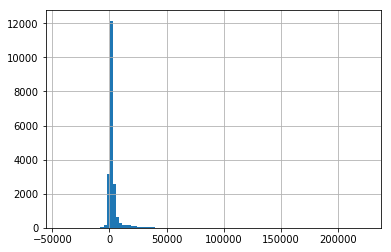

In [18]:
pd.Series(test1_churn_rg_pred_2).hist(bins=100)

#### <font color = 'red'>survival_time_pred 생성</font>

In [19]:
def get_test1_churn_rg_pred(pred_1, pred_2):
    pred_1_int = [7*(i-1)+1 for i in pred_1]
    
    pred = []
    
    for i,j in zip(pred_1_int, pred_2):
        if (i + j) < 0 :
            pred.append(1)
        elif (i + j)/2 > 63 :
            pred.append(63)
        else :
            pred.append((i+j)/2)
    
    return pred

In [20]:
#####
test1_churn_rg_pred = get_test1_churn_rg_pred(test1_churn_rg_pred_1, test1_churn_rg_pred_2)

In [21]:
test1_churn_rg_pred[:10]

[1, 63, 63, 1, 63, 63, 63, 63, 63, 63]

### spend_yn_model

#### <font color = 'red'>survival_time 예측값을 제일 마지막 column에 붙임</font>

In [22]:
test1_X['survival_time'] = test1_churn_rg_pred

In [23]:
test1_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6,survival_time
0,10,3,1.252251,4,5,11,2,0.555556,6,2,0.719474,0.071947,8.624290,0.000000,34.556743,10,0,8,1.000000,0.0,0.800000,0,0,0.000000,0.737650,0.494674,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000972,0.001291,0,1,1,0.000000,1.000000,0,0.000000,0.000,11,1,1.333333,1.0,0.0,0.000000,0.000000,1.918911,0.000000,0.294386,0.035204,0.035204,0.035204,0.035204,0.035204,27,2,16,1,18,0.055556,0.100000,0.830054,0.198491,0.0,0.000000,0.000000,0.000000,0.939389,0.042470,0.772419,0.239130,2,4,0.798163,0.199541,2,0.501503,0.125376,5.705665,4,0.000000,0,19.517147,3,1.0,0.0,0.750000,0,0,0.0,0.491767,0.247337,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000876,0.001099,3,0.533544,0.521214,0.000000,0.258004,0,0.035204,1,0,1,1,0,0.0,0.0,0.000000,1.918911,0.0,0.000000,0.294386,1,0.0,0.000000,0.000000,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1.0
1,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.0,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.000000,0.0,0.0,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.0,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.0,0.000000,0,0,0.0,3.442369,1.978695,0.0,0.00000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.0,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0,63.0
2,3,7,0.081923,2,5,21,3,0.375000,2,1,0.000000,0.000000,0.000000,0.000000,0.100846,0,0,1,0.000000,0.0,0.333333,0,0,0.000000,0.000000,0.000000,0.

In [24]:
#####
test1_spend_yn_pred = spend_yn_model.predict_proba(test1_X)
test1_spend_yn_pred = test1_spend_yn_pred[:,1]

Transforming...

estimator  0: [xrg: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [lgbm: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [ext: ExtraTreesClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  3: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



In [25]:
test1_spend_yn_pred

array([0.17400892, 0.05004092, 0.8079349 , ..., 0.01815154, 0.99876165,
       0.2619939 ], dtype=float32)

### spend_rg_model

In [26]:
def custom_loss_as(y_true,y_pred):
    d = y_true-y_pred
    bool_idx_1 = K.greater(d,0)
    score_max = (20*y_true) - 0.3*y_true
    score_under= (((10/9)*(y_pred/y_true)-1/9)*20*y_true) - 0.3*y_pred
    score_over = (20*y_true) - 0.3*y_pred
    loss1 = score_max - score_under
    loss2 = score_max - score_over
    loss = K.switch(bool_idx_1,loss1,loss2)
    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss_as

In [27]:
spend_rg_model =  joblib.load('../model/spend_rg_model.sav')

In [28]:
test1_spend_rg_pred = spend_rg_model.predict(test1_X)

In [29]:
test1_spend_rg_pred = test1_spend_rg_pred.reshape(-1)

In [30]:
test1_spend_rg_pred[:5]

array([ 0.0546547 ,  0.29540795,  0.29540795, -1.3974547 ,  6.954105  ],
      dtype=float32)

##### <font color='red'>음의 값이 나온 경우 0 으로 대체</font>

In [31]:
#####
test1_spend_rg_pred[test1_spend_rg_pred<0] = 0

## test1 예측하기

In [32]:
test1_df = pd.DataFrame({'acc_id' : test1_preprocess['acc_id'],
                        'survival_time_pred' : test1_churn_rg_pred,
                        'amount_spent_pred' : test1_spend_rg_pred,
                        'churn_proba' : test1_churn_yn_pred,
                        'spent_proba' : test1_spend_yn_pred
   })



def set_threshold(df, spent_threshold, churn_threshold):
    as_st = [[k, l] if ((i>=spent_threshold) & (j>=churn_threshold)) else (0,64) for i,j,k,l in zip(df['spent_proba'], df['churn_proba'], df['amount_spent_pred'],df['survival_time_pred'])]
    df['amount_spent'] = [i[0] for i in as_st]
    df['survival_time'] = [i[1] for i in as_st]
    
    submission = pd.DataFrame({
        'acc_id': df['acc_id'],
        'survival_time': df['survival_time'],
        'amount_spent': df['amount_spent']
    })
    return submission

test1_predict = set_threshold(test1_df, 0.05, 0.05)
#test1_predict.to_csv('./test1_predict.csv')

In [33]:
test1_predict

,acc_id,survival_time,amount_spent
0,7,1.000000,0.054655
1,15,63.000000,0.295408
2,16,63.000000,0.295408
3,18,64.000000,0.000000
4,19,63.000000,6.954105
5,22,63.000000,16.935991
6,24,63.000000,0.295408
7,28,64.000000,0.000000
8,39,63.000000,0.295408
9,51,63.000000,0.295408


# Model1 test2_preprocess

In [34]:
#test2_X = test2_preprocess.iloc[:,:] # acc_id 등 불필요한 것 걸러내기

In [35]:
#test1_preprocess = pd.read_csv('../preprocess/test1_preprocess.csv')
#test2_preprocess = pd.read_csv('../preprocess/test2_preprocess.csv')

In [36]:
test2_preprocess = pd.read_csv('../preprocess/test2_data.csv')

In [37]:
test2_preprocess.shape

(20000, 130)

In [38]:
test2_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,most_trade_item,indiv_trade_cnt,per_indiv_trade,most_trade_time,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,pay_yn,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent
0,1,28,2,88.551668,28,0,1,1,1.000000,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0,0.000000,0,0.0,16,28,0.0,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,1,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.000000,0.000000,0.000000,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478
1,3,21,9,2.694094,7,3,1,1,0.750000,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,5,4,0.400000,4,0.0,16,2,0.0,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,1,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.250000,0.000000,0.250000,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
2,9,4,4,0.081923,3,23,2,1,0.148148,2,1,0.015883,0.003971,0.005888,0.000000,0.066681,2,0,2,0.500000,0.000000,0.500000,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.028409,0.028409,3,10,13,0.230769,0.769231,5,13,1.000000,4,0.0,11,0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,1.756685,1.756685,1.169950,0.586735,0.586735,24,3,22,

In [39]:
test2_preprocess.most_trade_item.unique()

array([0, 5, 3, 1, 2, 4, 6], dtype=int64)

In [40]:
test2_preprocess.most_trade_time.unique()

array([0, 4, 2, 3, 1], dtype=int64)

## <font color = 'red'>test2_preprocess 더미변수</font>

In [41]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

def encoding_cate(x):

    x['pay_yn'] = x['pay_yn'].astype(object)
    x['most_trade_item'] = x['most_trade_item'].astype(object)
    x['most_trade_time'] = x['most_trade_time'].astype(object)

    print('There were {} columns before encoding categorical features'.format(x.shape[1]))
    combined = oneHotEncode(x, ['pay_yn','most_trade_time','most_trade_item'])
    print('There are {} columns after encoding categorical features'.format(combined.shape[1]))
    return combined

## 범주형 함수 encoding 적용
test2_preprocess = encoding_cate(test2_preprocess)

There were 130 columns before encoding categorical features
There are 141 columns after encoding categorical features


In [42]:
test2_preprocess.shape

(20000, 141)

In [43]:
test2_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,1,28,2,88.551668,28,0,1,1,1.000000,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.0,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.000000,0.000000,0.000000,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,3,21,9,2.694094,7,3,1,1,0.750000,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.0,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.250000,0.000000,0.250000,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,9,4,4,0.081923,3,23,2,1,0.148148,2,1,0.015883,0.003971,0.005888,0.000000,0.066681,2,0,2,0.500000,0.000000,0.500000,0,0,0.0

In [44]:
test2_X = test2_preprocess.iloc[:,1:] # acc_id 등 불필요한 것 걸러내기

In [45]:
test2_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,28,2,88.551668,28,0,1,1,1.000000,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.0,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.000000,0.000000,0.000000,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,21,9,2.694094,7,3,1,1,0.750000,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.0,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.250000,0.000000,0.250000,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,4,4,0.081923,3,23,2,1,0.148148,2,1,0.015883,0.003971,0.005888,0.000000,0.066681,2,0,2,0.500000,0.000000,0.500000,0,0,0.000000,0.00000

## model load

In [46]:
import joblib
import vecstack
import xgboost as xgb
import lightgbm as lgb
import keras.backend as K


In [47]:
def custom_loss(y_true,y_pred):
    d = y_true-y_pred
    score_max = 30
    score = 30*K.exp(-(K.square(d)/450))
    loss = score_max - score

    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss

In [48]:
glob.glob('../model/*')

['../model\\churn_rg_model_1.sav',
 '../model\\churn_rg_model_2.sav',
 '../model\\churn_yn_model.pkl',
 '../model\\drive-download-20190910T080328Z-001',
 '../model\\first_churn_rg_model_1.sav',
 '../model\\first_churn_rg_model_2.sav',
 '../model\\first_churn_yn_model.pkl',
 '../model\\first_spend_rg_model.sav',
 '../model\\first_spend_yn_model.pkl',
 '../model\\spend_rg_model.sav',
 '../model\\spend_yn_model.pkl']

In [49]:
# 이탈 분류 모델
churn_yn_model = joblib.load('../model\\churn_yn_model.pkl')

# 이탈시기 예측 모델
churn_rg_model_1 = joblib.load('../model\\churn_rg_model_1.sav')
churn_rg_model_2 =  joblib.load('../model/churn_rg_model_2.sav')

# 과금 분류 모델
spend_yn_model = joblib.load('../model\\spend_yn_model.pkl')
                                
# 과금액 예측 모델은 나중에 로드함

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  Us

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

### churn_yn

In [50]:
#####
test2_churn_yn_pred = churn_yn_model.predict_proba(test2_X)
test2_churn_yn_pred = test2_churn_yn_pred[:,1]

In [51]:
pd.DataFrame(test2_churn_yn_pred).head(5)

,0
0,0.721709
1,0.806842
2,0.940631
3,0.661283
4,0.289241


### churn_rg_model_1

In [52]:
#####
test2_churn_rg_pred_1 = churn_rg_model_1.predict(test2_X)

In [53]:
test2_churn_rg_pred_1

array([5, 3, 1, ..., 1, 1, 4], dtype=int64)

### <font color='red'>churn_rg_model_2</font>

In [54]:
#####
test2_churn_rg_pred_2 = churn_rg_model_2.predict(test2_X)

In [55]:
test2_churn_rg_pred_2 = test2_churn_rg_pred_2.reshape(-1)

In [56]:
test2_churn_rg_pred_2

array([-235.32608, 3001.804  , -784.51245, ..., 9938.327  ,  134.61862,
       3258.9329 ], dtype=float32)

#### <font color = 'red'>survival_time_pred 생성</font>

In [57]:
def get_test2_churn_rg_pred(pred_1, pred_2):
    pred_1_int = [7*(i-1)+1 for i in pred_1]
    
    pred = []
    
    for i,j in zip(pred_1_int, pred_2):
        if (i + j) < 0 :
            pred.append(1)
        elif (i + j)/2 > 63 :
            pred.append(63)
        else :
            pred.append((i+j)/2)
    
    return pred

In [58]:
#####
test2_churn_rg_pred = get_test2_churn_rg_pred(test2_churn_rg_pred_1, test2_churn_rg_pred_2)

In [59]:
test2_churn_rg_pred[:10]

[1, 63, 1, 63, 63, 63, 63, 63, 63, 63]

### spend_yn_model

#### <font color = 'red'>survival_time 예측값을 제일 마지막 column에 붙임</font>

In [60]:
test2_X['survival_time'] = test2_churn_rg_pred

In [61]:
test2_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6,survival_time
0,28,2,88.551668,28,0,1,1,1.000000,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.0,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.000000,0.000000,0.000000,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1.0
1,21,9,2.694094,7,3,1,1,0.750000,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.0,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.250000,0.000000,0.250000,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0,63.0
2,4,4,0.081923,3,23,2,1,0.148148,2,1,0.015883,0.003971,0.005888,0.000000,0.066681,2,0,2,0.500000,0.000000,0.5000

In [62]:
#####
test2_spend_yn_pred = spend_yn_model.predict_proba(test2_X)
test2_spend_yn_pred = test2_spend_yn_pred[:,1]

Transforming...

estimator  0: [xrg: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [lgbm: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [ext: ExtraTreesClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  3: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



In [63]:
test2_spend_yn_pred

array([0.46330485, 0.9888909 , 0.6362838 , ..., 0.06332503, 0.10942569,
       0.9229602 ], dtype=float32)

### spend_rg_model

In [64]:
def custom_loss_as(y_true,y_pred):
    d = y_true-y_pred
    bool_idx_1 = K.greater(d,0)
    score_max = (20*y_true) - 0.3*y_true
    score_under= (((10/9)*(y_pred/y_true)-1/9)*20*y_true) - 0.3*y_pred
    score_over = (20*y_true) - 0.3*y_pred
    loss1 = score_max - score_under
    loss2 = score_max - score_over
    loss = K.switch(bool_idx_1,loss1,loss2)
    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss_as

In [65]:
spend_rg_model =  joblib.load('../model/spend_rg_model.sav')

In [66]:
test2_spend_rg_pred = spend_rg_model.predict(test2_X)

In [67]:
test2_spend_rg_pred = test2_spend_rg_pred.reshape(-1)

In [68]:
test2_spend_rg_pred[:5]

array([12.333472  ,  4.866617  , -0.44992256,  4.862143  , 53.7031    ],
      dtype=float32)

##### <font color='red'>음의 값이 나온 경우 0 으로 대체</font>

In [69]:
#####
test2_spend_rg_pred[test2_spend_rg_pred<0] = 0

## test2 예측하기

In [70]:
test2_df = pd.DataFrame({'acc_id' : test2_preprocess['acc_id'],
                        'survival_time_pred' : test2_churn_rg_pred,
                        'amount_spent_pred' : test2_spend_rg_pred,
                        'churn_proba' : test2_churn_yn_pred,
                        'spent_proba' : test2_spend_yn_pred
   })



def set_threshold(df, spent_threshold, churn_threshold):
    as_st = [[k, l] if ((i>=spent_threshold) & (j>=churn_threshold)) else (0,64) for i,j,k,l in zip(df['spent_proba'], df['churn_proba'], df['amount_spent_pred'],df['survival_time_pred'])]
    df['amount_spent'] = [i[0] for i in as_st]
    df['survival_time'] = [i[1] for i in as_st]
    
    submission = pd.DataFrame({
        'acc_id': df['acc_id'],
        'survival_time': df['survival_time'],
        'amount_spent': df['amount_spent']
    })
    return submission

test2_predict = set_threshold(test2_df, 0.05, 0.05)
#test2_predict.to_csv('./test2_predict.csv')

In [71]:
test2_predict

,acc_id,survival_time,amount_spent
0,1,1.0,12.333472
1,3,63.0,4.866617
2,9,1.0,0.000000
3,14,63.0,4.862143
4,26,63.0,53.703098
5,27,64.0,0.000000
6,32,63.0,0.295408
7,44,63.0,0.295408
8,45,63.0,2.360536
9,49,64.0,0.000000


# Model2 test1_preprocess

In [101]:
#test1_preprocess = pd.read_csv('../preprocess/test1_preprocess.csv')
#test2_preprocess = pd.read_csv('../preprocess/test2_preprocess.csv')

In [72]:
test1_preprocess = pd.read_csv('../preprocess/test1_data.csv')

In [73]:
test1_preprocess.shape

(20000, 130)

In [74]:
test1_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,most_trade_item,indiv_trade_cnt,per_indiv_trade,most_trade_time,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,pay_yn,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent
0,7,10,3,1.252251,4,5,11,2,0.555556,6,2,0.719474,0.071947,8.624290,0.000000,34.556743,10,0,8,1.000000,0.0,0.800000,0,0,0.000000,0.737650,0.494674,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000972,0.001291,0,1,1,0.000000,1.000000,3,0,0.000000,3,0.000,11,1,1.333333,1.0,0.0,0.000000,0.000000,1.918911,0.000000,0.294386,1,0.035204,0.035204,0.035204,0.035204,0.035204,27,2,16,1,18,0.055556,0.100000,0.830054,0.198491,0.0,0.000000,0.000000,0.000000,0.939389,0.042470,0.772419,0.239130,2,4,0.798163,0.199541,2,0.501503,0.125376,5.705665,4,0.000000,0,19.517147,3,1.0,0.0,0.750000,0,0,0.0,0.491767,0.247337,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000876,0.001099,3,0.533544,0.521214,0.000000,0.258004,0,0.035204,1,0,1,1,0,0.0,0.0,0.000000,1.918911,0.0,0.000000,0.294386,1,0.0,0.000000,0.000000
1,15,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.0,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0,0.000000,0,0.000,16,15,0.000000,0.0,0.0,0.000000,39.041128,0.000000,2.027007,2.256961,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.0,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.0,0.000000,0,0,0.0,3.442369,1.978695,0.0,0.00000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.0,-0.606050,0.559680
2,16,3,7,0.081923,2,5,21,3,0.375000,2,1,0.000000,0.000000,0.000000,0.000000,0.100846,0,0,1,0.000000,0.0,0.333333,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.033401,0.034526,0,0,0,0.000000,0.000000,0,0,0.000000,0,0.000,9,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.035204,0.035204,0.035204,0.035204,0.035204,27,2,6,1,8,0.125000,0.333333,

In [75]:
model2_test1_preprocess = test1_preprocess.loc[test1_preprocess.first_app==1, :]

In [76]:
model2_test1_preprocess.shape

(14046, 130)

In [77]:
model2_test1_preprocess.most_trade_item.unique()

array([0, 1, 3, 2, 6, 4, 5], dtype=int64)

In [78]:
model2_test1_preprocess.most_trade_time.unique()

array([0, 4, 2, 3, 1], dtype=int64)

## <font color = 'red'>model2_test1_preprocess 더미변수</font>

In [79]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

def encoding_cate(x):

    x['pay_yn'] = x['pay_yn'].astype(object)
    x['most_trade_item'] = x['most_trade_item'].astype(object)
    x['most_trade_time'] = x['most_trade_time'].astype(object)

    print('There were {} columns before encoding categorical features'.format(x.shape[1]))
    combined = oneHotEncode(x, ['pay_yn','most_trade_time','most_trade_item'])
    print('There are {} columns after encoding categorical features'.format(combined.shape[1]))
    return combined

## 범주형 함수 encoding 적용
model2_test1_preprocess = encoding_cate(model2_test1_preprocess)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

There were 130 columns before encoding categorical features
There are 141 columns after encoding categorical features


In [80]:
model2_test1_preprocess.shape

(14046, 141)

In [81]:
model2_test1_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
1,15,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.000000,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.0,0.0,0.000000,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.000000,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.000000,0.000000,0,0,0.000000,3.442369,1.978695,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.00000,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,19,28,4,84.139533,28,0,1,1,1.000000,0,4,79.866399,2.852371,0.271431,0.954236,0.007157,28,28,10,1.000000,1.000000,0.357143,2,2,0.071429,0.737650,0.494674,0.0,37.465503,0.445278,0.000000,0.000000,0.0,0.227807,1.863396,12,53,65,0.184615,0.815385,29,0.446154,0.025,17,10,0.0,0.0,0.000000,3.131975,9.464516,1.918911,2.815288,4.219536,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,0.429791,0.066711,0.000000,0.010759,0.043352,0.048225,0.125851,0.012870,0.262178,0.155216,1,7,22.044291,3.149184,3,16.821645,2.403092,0.034323,7,0.139444,7,0.000976,6,1.0,1.000000,0.857143,0,0,0.000000,0.491767,0.494674,0.0,11.502370,0.521785,0.000000,0.000000,0.0,0.275024,0.275024,2,0.386708,-0.524457,-0.531039,-0.134633,3,0.000000,0,6,8,14,14,0.0,0.0,0.000000,0.479728,0.0,0.112612,0.196258,1,0.00000,-0.369274,-0.600341,1,0,0,0,0,0,1,0,1,0,0,0,0,0
7,28,28,1,88.738921,28,0,1,1,1.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,

In [82]:
model2_test1_X = model2_test1_preprocess.iloc[:,1:] # acc_id 등 불필요한 것 걸러내기

In [83]:
model2_test1_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
1,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.000000,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.0,0.0,0.000000,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.000000,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.000000,0.000000,0,0,0.000000,3.442369,1.978695,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.00000,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,28,4,84.139533,28,0,1,1,1.000000,0,4,79.866399,2.852371,0.271431,0.954236,0.007157,28,28,10,1.000000,1.000000,0.357143,2,2,0.071429,0.737650,0.494674,0.0,37.465503,0.445278,0.000000,0.000000,0.0,0.227807,1.863396,12,53,65,0.184615,0.815385,29,0.446154,0.025,17,10,0.0,0.0,0.000000,3.131975,9.464516,1.918911,2.815288,4.219536,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,0.429791,0.066711,0.000000,0.010759,0.043352,0.048225,0.125851,0.012870,0.262178,0.155216,1,7,22.044291,3.149184,3,16.821645,2.403092,0.034323,7,0.139444,7,0.000976,6,1.0,1.000000,0.857143,0,0,0.000000,0.491767,0.494674,0.0,11.502370,0.521785,0.000000,0.000000,0.0,0.275024,0.275024,2,0.386708,-0.524457,-0.531039,-0.134633,3,0.000000,0,6,8,14,14,0.0,0.0,0.000000,0.479728,0.0,0.112612,0.196258,1,0.00000,-0.369274,-0.600341,1,0,0,0,0,0,1,0,1,0,0,0,0,0
7,28,1,88.738921,28,0,1,1,1.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,0

## model load

In [84]:
import joblib
import vecstack
import xgboost as xgb
import lightgbm as lgb
import keras.backend as K


In [85]:
def custom_loss(y_true,y_pred):
    d = y_true-y_pred
    score_max = 30
    score = 30*K.exp(-(K.square(d)/450))
    loss = score_max - score

    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss

In [86]:
glob.glob('../model/*')

['../model\\churn_rg_model_1.sav',
 '../model\\churn_rg_model_2.sav',
 '../model\\churn_yn_model.pkl',
 '../model\\drive-download-20190910T080328Z-001',
 '../model\\first_churn_rg_model_1.sav',
 '../model\\first_churn_rg_model_2.sav',
 '../model\\first_churn_yn_model.pkl',
 '../model\\first_spend_rg_model.sav',
 '../model\\first_spend_yn_model.pkl',
 '../model\\spend_rg_model.sav',
 '../model\\spend_yn_model.pkl']

In [87]:
# 이탈 분류 모델
churn_yn_model = joblib.load('../model\\first_churn_yn_model.pkl')

# 이탈시기 예측 모델
churn_rg_model_1 = joblib.load('../model\\first_churn_rg_model_1.sav')
churn_rg_model_2 =  joblib.load('../model/first_churn_rg_model_2.sav')

# 과금 분류 모델
spend_yn_model = joblib.load('../model\\first_spend_yn_model.pkl')
                                
# 과금액 예측 모델은 나중에 로드함

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  Us

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

### churn_yn

In [88]:
#####
model2_test1_churn_yn_pred = churn_yn_model.predict_proba(model2_test1_X)
model2_test1_churn_yn_pred = model2_test1_churn_yn_pred[:,1]

In [89]:
pd.DataFrame(model2_test1_churn_yn_pred).head(5)

,0
0,0.842627
1,0.407763
2,0.278424
3,0.136939
4,0.814464


### churn_rg_model_1

In [90]:
#####
model2_test1_churn_rg_pred_1 = churn_rg_model_1.predict(model2_test1_X)

In [91]:
model2_test1_churn_rg_pred_1

array([6, 5, 1, ..., 6, 2, 4], dtype=int64)

### <font color='red'>churn_rg_model_2</font>

In [92]:
#####
model2_test1_churn_rg_pred_2 = churn_rg_model_2.predict(model2_test1_X)

In [93]:
model2_test1_churn_rg_pred_2 = model2_test1_churn_rg_pred_2.reshape(-1)

In [94]:
pd.Series(model2_test1_churn_rg_pred_2).max()

1453042.4

#### <font color = 'red'>survival_time_pred 생성</font>

In [95]:
def get_model2_test1_churn_rg_pred(pred_1, pred_2):
    pred_1_int = [7*(i-1)+1 for i in pred_1]
    
    pred = []
    
    for i,j in zip(pred_1_int, pred_2):
        if (i + j) < 0 :
            pred.append(1)
        elif (i + j)/2 > 63 :
            pred.append(63)
        else :
            pred.append((i+j)/2)
    
    return pred

In [96]:
#####
model2_test1_churn_rg_pred = get_model2_test1_churn_rg_pred(model2_test1_churn_rg_pred_1, model2_test1_churn_rg_pred_2)

In [97]:
model2_test1_churn_rg_pred[:10]

[1,
 63,
 63,
 36.135215759277344,
 40.18421936035156,
 63,
 63,
 63,
 3.800140380859375,
 63]

### spend_yn_model

#### <font color = 'red'>survival_time 예측값을 제일 마지막 column에 붙임</font>

In [98]:
model2_test1_X['survival_time'] = model2_test1_churn_rg_pred

In [99]:
model2_test1_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6,survival_time
1,28,3,85.705431,28,0,1,1,1.000000,0,3,18.207875,0.650281,0.630317,0.000000,0.000000,27,0,0,0.964286,0.000000,0.000000,0,0,0.000000,7.868271,6.183422,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000240,0.023029,0,0,0,0.000000,0.000000,0,0.000000,0.000,16,15,0.0,0.0,0.000000,0.000000,39.041128,0.000000,2.027007,2.256961,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,1.245082,0.292581,0.000000,0.000000,0.952900,0.000000,0.074162,0.047778,1.471352,0.234990,3,7,21.182930,3.026133,3,4.216479,0.602354,0.148216,7,0.000000,0,0.000000,0,1.0,0.000000,0.000000,0,0,0.000000,3.442369,1.978695,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000964,0.006601,3,-0.081484,-0.200735,0.000000,0.000000,0,0.000000,0,0,0,0,0,0.0,0.0,16.562903,0.000000,0.0,0.112612,0.785030,4,0.00000,-0.606050,0.559680,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1.000000
4,28,4,84.139533,28,0,1,1,1.000000,0,4,79.866399,2.852371,0.271431,0.954236,0.007157,28,28,10,1.000000,1.000000,0.357143,2,2,0.071429,0.737650,0.494674,0.0,37.465503,0.445278,0.000000,0.000000,0.0,0.227807,1.863396,12,53,65,0.184615,0.815385,29,0.446154,0.025,17,10,0.0,0.0,0.000000,3.131975,9.464516,1.918911,2.815288,4.219536,0.000000,0.000000,0.000000,0.000000,0.000000,0,29,0,0,0,0.000000,0.000000,0.429791,0.066711,0.000000,0.010759,0.043352,0.048225,0.125851,0.012870,0.262178,0.155216,1,7,22.044291,3.149184,3,16.821645,2.403092,0.034323,7,0.139444,7,0.000976,6,1.0,1.000000,0.857143,0,0,0.000000,0.491767,0.494674,0.0,11.502370,0.521785,0.000000,0.000000,0.0,0.275024,0.275024,2,0.386708,-0.524457,-0.531039,-0.134633,3,0.000000,0,6,8,14,14,0.0,0.0,0.000000,0.479728,0.0,0.112612,0.196258,1,0.00000,-0.369274,-0.600341,1,0,0,0,0,0,1,0,1,0,0,0,0,0,63.000000
7,28,1,88.738921,28,0,1,1,1.000000,0,1,0.000000,0.000000,0.000000,0

In [100]:
#####
model2_test1_spend_yn_pred = spend_yn_model.predict_proba(model2_test1_X)
model2_test1_spend_yn_pred = model2_test1_spend_yn_pred[:,1]

Transforming...

estimator  0: [xrg: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [lgbm: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [ext: ExtraTreesClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  3: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



In [101]:
model2_test1_spend_yn_pred

array([0.17442378, 0.8496265 , 0.00225038, ..., 0.01087738, 0.04827978,
       0.7653013 ], dtype=float32)

### spend_rg_model

In [102]:
def custom_loss_as(y_true,y_pred):
    d = y_true-y_pred
    bool_idx_1 = K.greater(d,0)
    score_max = (20*y_true) - 0.3*y_true
    score_under= (((10/9)*(y_pred/y_true)-1/9)*20*y_true) - 0.3*y_pred
    score_over = (20*y_true) - 0.3*y_pred
    loss1 = score_max - score_under
    loss2 = score_max - score_over
    loss = K.switch(bool_idx_1,loss1,loss2)
    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss_as

In [103]:
spend_rg_model =  joblib.load('../model/spend_rg_model.sav')

In [104]:
model2_test1_spend_rg_pred = spend_rg_model.predict(model2_test1_X)

In [105]:
model2_test1_spend_rg_pred = model2_test1_spend_rg_pred.reshape(-1)

In [106]:
model2_test1_spend_rg_pred[:15]

array([ 0.3159224 ,  6.954105  , 18.10623   ,  0.2286886 ,  0.29540795,
        1.0554817 , -0.8625054 , 20.075935  ,  1.6922662 ,  0.29540795,
       26.01595   , 31.496881  ,  9.389112  ,  0.41097003,  8.973278  ],
      dtype=float32)

##### <font color='red'>음의 값이 나온 경우 0 으로 대체</font>

In [107]:
#####
model2_test1_spend_rg_pred[model2_test1_spend_rg_pred<0] = 0

## <font color='red'>model2_test1 예측하기</font>

In [108]:
model2_test1_df = pd.DataFrame({'acc_id' : model2_test1_preprocess['acc_id'],
                        'survival_time_pred' : model2_test1_churn_rg_pred,
                        'amount_spent_pred' : model2_test1_spend_rg_pred,
                        'churn_proba' : model2_test1_churn_yn_pred,
                        'spent_proba' : model2_test1_spend_yn_pred
   })



def set_threshold(df, spent_threshold, churn_threshold):
    as_st = [[k, l] if ((i>=spent_threshold) & (j>=churn_threshold)) else (0,64) for i,j,k,l in zip(df['spent_proba'], df['churn_proba'], df['amount_spent_pred'],df['survival_time_pred'])]
    df['amount_spent'] = [i[0] for i in as_st]
    df['survival_time'] = [i[1] for i in as_st]
    
    submission = pd.DataFrame({
        'acc_id': df['acc_id'],
        'survival_time': df['survival_time'],
        'amount_spent': df['amount_spent']
    })
    return submission

model2_test1_predict = set_threshold(model2_test1_df, 0.05, 0.05)
#model2_test1_predict.to_csv('./model2_test1_predict.csv')

In [109]:
model2_test1_predict

,acc_id,survival_time,amount_spent
1,15,1.000000,0.315922
4,19,63.000000,6.954105
7,28,64.000000,0.000000
8,39,36.135216,0.228689
10,55,40.184219,0.295408
11,56,64.000000,0.000000
12,58,64.000000,0.000000
13,70,63.000000,20.075935
14,80,64.000000,0.000000
15,82,64.000000,0.000000


# Model2 test1_preprocess

In [110]:
#test1_preprocess = pd.read_csv('../preprocess/test1_preprocess.csv')
#test2_preprocess = pd.read_csv('../preprocess/test2_preprocess.csv')

In [111]:
test2_preprocess = pd.read_csv('../preprocess/test2_data.csv')

In [112]:
test2_preprocess.shape

(20000, 130)

In [113]:
test2_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,most_trade_item,indiv_trade_cnt,per_indiv_trade,most_trade_time,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,pay_yn,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent
0,1,28,2,88.551668,28,0,1,1,1.000000,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0,0.000000,0,0.0,16,28,0.0,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,1,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.000000,0.000000,0.000000,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478
1,3,21,9,2.694094,7,3,1,1,0.750000,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,5,4,0.400000,4,0.0,16,2,0.0,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,1,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.250000,0.000000,0.250000,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
2,9,4,4,0.081923,3,23,2,1,0.148148,2,1,0.015883,0.003971,0.005888,0.000000,0.066681,2,0,2,0.500000,0.000000,0.500000,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.028409,0.028409,3,10,13,0.230769,0.769231,5,13,1.000000,4,0.0,11,0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,1.756685,1.756685,1.169950,0.586735,0.586735,24,3,22,

In [114]:
model2_test2_preprocess = test2_preprocess.loc[test2_preprocess.first_app==1, :]

In [115]:
model2_test2_preprocess.shape

(13487, 130)

In [116]:
model2_test2_preprocess.most_trade_item.unique()

array([0, 5, 3, 1, 2, 6, 4], dtype=int64)

In [117]:
model2_test2_preprocess.most_trade_time.unique()

array([0, 4, 3, 1, 2], dtype=int64)

## <font color = 'red'>model2_test2_preprocess 컬럼 순서맞추기</font>

## <font color = 'red'>model2_test2_preprocess 더미변수</font>

In [118]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

def encoding_cate(x):

    x['pay_yn'] = x['pay_yn'].astype(object)
    x['most_trade_item'] = x['most_trade_item'].astype(object)
    x['most_trade_time'] = x['most_trade_time'].astype(object)

    print('There were {} columns before encoding categorical features'.format(x.shape[1]))
    combined = oneHotEncode(x, ['pay_yn','most_trade_time','most_trade_item'])
    print('There are {} columns after encoding categorical features'.format(combined.shape[1]))
    return combined

## 범주형 함수 encoding 적용
model2_test2_preprocess = encoding_cate(model2_test2_preprocess)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

There were 130 columns before encoding categorical features
There are 141 columns after encoding categorical features


In [119]:
model2_test2_preprocess.shape

(13487, 141)

In [120]:
model2_test2_preprocess.head()

,acc_id,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,1,28,2,88.551668,28,0,1,1,1.00,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.000000,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.00,0.0,0.00,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,3,21,9,2.694094,7,3,1,1,0.75,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.000000,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.25,0.0,0.25,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,26,28,6,31.816526,28,0,1,1,1.00,0,4,3.774791,0.134814,0.428995,0.009611,0.000868,4,3,1,0.142857,0.107143,0.035714,5,5,0.178571,29.506016,29.680428

In [121]:
model2_test2_X = model2_test2_preprocess.iloc[:,1:] # acc_id 등 불필요한 것 걸러내기

In [122]:
model2_test2_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6
0,28,2,88.551668,28,0,1,1,1.00,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.000000,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.00,0.0,0.00,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,21,9,2.694094,7,3,1,1,0.75,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.000000,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.25,0.0,0.25,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,28,6,31.816526,28,0,1,1,1.00,0,4,3.774791,0.134814,0.428995,0.009611,0.000868,4,3,1,0.142857,0.107143,0.035714,5,5,0.178571,29.506016,29.680428,0.0,83.157199

## model load

In [123]:
import joblib
import vecstack
import xgboost as xgb
import lightgbm as lgb
import keras.backend as K


In [124]:
def custom_loss(y_true,y_pred):
    d = y_true-y_pred
    score_max = 30
    score = 30*K.exp(-(K.square(d)/450))
    loss = score_max - score

    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss

In [125]:
glob.glob('../model/*')

['../model\\churn_rg_model_1.sav',
 '../model\\churn_rg_model_2.sav',
 '../model\\churn_yn_model.pkl',
 '../model\\drive-download-20190910T080328Z-001',
 '../model\\first_churn_rg_model_1.sav',
 '../model\\first_churn_rg_model_2.sav',
 '../model\\first_churn_yn_model.pkl',
 '../model\\first_spend_rg_model.sav',
 '../model\\first_spend_yn_model.pkl',
 '../model\\spend_rg_model.sav',
 '../model\\spend_yn_model.pkl']

In [126]:
# 이탈 분류 모델
churn_yn_model = joblib.load('../model\\first_churn_yn_model.pkl')

# 이탈시기 예측 모델
churn_rg_model_1 = joblib.load('../model\\first_churn_rg_model_1.sav')
churn_rg_model_2 =  joblib.load('../model/first_churn_rg_model_2.sav')

# 과금 분류 모델
spend_yn_model = joblib.load('../model\\first_spend_yn_model.pkl')
                                
# 과금액 예측 모델은 나중에 로드함

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  Us

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarn

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.

### churn_yn

In [127]:
#####
model2_test2_churn_yn_pred = churn_yn_model.predict_proba(model2_test2_X)
model2_test2_churn_yn_pred = model2_test2_churn_yn_pred[:,1]

In [128]:
pd.DataFrame(model2_test2_churn_yn_pred).head(5)

,0
0,0.817149
1,0.923852
2,0.119076
3,0.568946
4,0.882870


### churn_rg_model_1

In [129]:
#####
model2_test2_churn_rg_pred_1 = churn_rg_model_1.predict(model2_test2_X)

In [130]:
model2_test2_churn_rg_pred_1

array([6, 3, 5, ..., 1, 1, 4], dtype=int64)

### <font color='red'>churn_rg_model_2</font>

In [131]:
#####
model2_test2_churn_rg_pred_2 = churn_rg_model_2.predict(model2_test2_X)

In [132]:
model2_test2_churn_rg_pred_2 = model2_test2_churn_rg_pred_2.reshape(-1)

In [133]:
pd.Series(model2_test2_churn_rg_pred_2).max()

390807.1

#### <font color = 'red'>survival_time_pred 생성</font>

In [134]:
def get_model2_test2_churn_rg_pred(pred_1, pred_2):
    pred_1_int = [7*(i-1)+1 for i in pred_1]
    
    pred = []
    
    for i,j in zip(pred_1_int, pred_2):
        if (i + j) < 0 :
            pred.append(1)
        elif (i + j)/2 > 63 :
            pred.append(63)
        else :
            pred.append((i+j)/2)
    
    return pred

In [135]:
#####
model2_test2_churn_rg_pred = get_model2_test2_churn_rg_pred(model2_test2_churn_rg_pred_1, model2_test2_churn_rg_pred_2)

In [136]:
model2_test2_churn_rg_pred[:10]

[1, 1, 63, 1, 63, 63, 63, 63, 1, 63]

### spend_yn_model

#### <font color = 'red'>survival_time 예측값을 제일 마지막 column에 붙임</font>

In [137]:
model2_test2_X['survival_time'] = model2_test2_churn_rg_pred

In [138]:
model2_test2_X.head()

,login_cnt,char_cnt,total_playtime,conseq_log,conseq_nolog,first_app,start_week,per_log,switchlog_cnt,server_cnt,total_npckill,mean_npckill,total_soloexp,total_partyexp,total_questexp,soloexp_cnt,partyexp_cnt,questexp_cnt,per_soloday,per_partyday,per_questday,total_bossattack,bossattack_cnt,per_bossattack,total_death,total_revive,total_recovery,total_fishing,per_fishing,total_privateshop,per_privateshop,total_enchant,total_moneychange,total_moneychange_abs,sell_cnt,buy_cnt,trade_cnt,per_sell,per_buy,indiv_trade_cnt,per_indiv_trade,random_att_ratio_avg,max_level,combat_login_cnt,diff_level_avg,change_level_avg,total_pledge_cnt,total_random_attacker_cnt,total_random_defender_cnt,total_temp_cnt,total_etc_cnt,total_num_opponent,total_pay_amount,mean_pay_amount,max_pay_amount,min_pay_amount,last_pay_amount,first_pay_day,days_since_last_pay,first_pay_from_start,pay_day_cnt,avail_day,pmday_availday_ratio,pmday_playday_ratio,pl_play_char_cnt,pl_combat_char_cnt,pl_pledge_combat_cnt,pl_random_attacker_cnt,pl_random_defender_cnt,pl_same_pledge_cnt,pl_temp_cnt,pl_etc_cnt,pl_combat_play_time,pl_combat_char_ratio,pl_pledge_count,login_cnt_4,total_playtime_4,mean_playtime_4,server_cnt_4,total_npckill_4,mean_npckill_4,total_soloexp_4,soloexp_cnt_4,total_partyexp_4,partyexp_cnt_4,total_questexp_4,questexp_cnt_4,per_soloday_4,per_partyday_4,per_questday_4,total_bossattack_4,bossattack_cnt_4,total_death_4,per_bossattack_4,total_revive_4,total_recovery_4,total_fishing_4,per_fishing_4,total_privateshop_4,per_privateshop_4,total_enchant_4,total_moneychange_4,total_moneychange_abs_4,char_cnt_4,tend_playtime,tend_soloexp,tend_partyexp,tend_questexp,maxplay_cnt,total_payment_4,payment_cnt_4,sell_cnt_4,buy_cnt_4,trade_cnt_4,indiv_trade_cnt_4,total_pledge_cnt_4,total_random_attacker_cnt_4,total_random_defender_cnt_4,total_temp_cnt_4,total_same_pledge_cnt_4,total_etc_cnt_4,total_num_opponent_4,combat_login_cnt_4,tend_pledge_cnt,tend_etc_cnt,tend_num_opponent,pay_yn_0,pay_yn_1,most_trade_time_0,most_trade_time_1,most_trade_time_2,most_trade_time_3,most_trade_time_4,most_trade_item_0,most_trade_item_1,most_trade_item_2,most_trade_item_3,most_trade_item_4,most_trade_item_5,most_trade_item_6,survival_time
0,28,2,88.551668,28,0,1,1,1.00,0,1,58.285882,2.081639,0.512386,0.000000,0.000000,28,0,0,1.000000,0.000000,0.000000,0,0,0.000000,2.704718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000116,0.003433,0,0,0,0.000000,0.000000,0,0.000000,0.0,16,28,0.000000,0.0,0.000000,0.0,80.448385,0.479728,37.499638,18.840721,0.348521,0.348521,0.348521,0.348521,0.348521,12,17,11,1,28,0.035714,0.035714,0.380227,0.348004,0.000000,0.000000,1.555807,0.000000,0.031784,0.467166,1.141920,0.915254,1,7,22.559235,3.222748,1,14.551025,2.078718,0.127720,7,0.000000,0,0.000000,0,1.00,0.0,0.00,0,0,0.000000,1.229417,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000108,0.001012,2,0.128889,-0.020371,0.000000,0.000000,9,0.000000,0,0,0,0,0,0.000000,0.0,27.210483,0.000000,0.000000,4.391850,3.336378,7,0.000000,-0.773638,-0.628478,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1.0
1,21,9,2.694094,7,3,1,1,0.75,6,5,0.092596,0.004409,0.010214,0.000000,0.078912,5,0,7,0.238095,0.000000,0.333333,2,2,0.095238,0.000000,0.000000,0.0,1.025441,0.380626,0.0,0.0,0.0,0.019400,0.051625,4,6,10,0.400000,0.600000,4,0.400000,0.0,16,2,0.000000,0.0,0.000000,0.0,1.183064,0.000000,0.112612,0.196258,5.984698,5.984698,4.107146,0.176021,4.107146,2,13,1,5,28,0.178571,0.238095,0.076690,0.004511,0.000000,0.000000,0.000000,0.000000,0.024721,0.000000,0.000767,0.058824,1,4,0.503241,0.125810,2,0.038525,0.009631,0.002197,1,0.000000,0,0.009543,1,0.25,0.0,0.25,1,1,0.250000,0.000000,0.000000,0.0,0.163807,0.325504,0.0,0.0,0.0,-0.000082,0.001714,2,-0.049435,0.047340,0.000000,-0.094195,0,0.000000,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1.0
4,28,6,31.816526,28,0,1,1,1.00,0,4,3.774791,0.134814,0.428995,0.009611,0.000868,4,3,1,0.142857,0.107143,0.035714,5,5,0.178571,29.506016,2

In [139]:
#####
model2_test2_spend_yn_pred = spend_yn_model.predict_proba(model2_test2_X)
model2_test2_spend_yn_pred = model2_test2_spend_yn_pred[:,1]

Transforming...

estimator  0: [xrg: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [lgbm: LGBMClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [ext: ExtraTreesClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  3: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE



In [140]:
model2_test2_spend_yn_pred

array([0.54967505, 0.72566336, 0.97516394, ..., 0.00589069, 0.06436575,
       0.6899084 ], dtype=float32)

### spend_rg_model

In [141]:
def custom_loss_as(y_true,y_pred):
    d = y_true-y_pred
    bool_idx_1 = K.greater(d,0)
    score_max = (20*y_true) - 0.3*y_true
    score_under= (((10/9)*(y_pred/y_true)-1/9)*20*y_true) - 0.3*y_pred
    score_over = (20*y_true) - 0.3*y_pred
    loss1 = score_max - score_under
    loss2 = score_max - score_over
    loss = K.switch(bool_idx_1,loss1,loss2)
    return K.sum(loss)

import keras.losses
keras.losses.custom_loss = custom_loss_as

In [142]:
spend_rg_model =  joblib.load('../model/spend_rg_model.sav')

In [143]:
model2_test2_spend_rg_pred = spend_rg_model.predict(model2_test2_X)

In [144]:
model2_test2_spend_rg_pred = model2_test2_spend_rg_pred.reshape(-1)

In [145]:
model2_test2_spend_rg_pred[:15]

array([ 12.333472  ,  22.234247  ,  53.7031    ,   0.29540795,
         0.29540795,   0.29540795,   2.3605356 , 123.03673   ,
         1.4115069 ,   8.033744  ,   0.29540795,   0.29540795,
        23.197493  ,   0.29540795,   7.147978  ], dtype=float32)

##### <font color='red'>음의 값이 나온 경우 0 으로 대체</font>

In [146]:
#####
model2_test2_spend_rg_pred[model2_test2_spend_rg_pred<0] = 0

## <font color='red'>model2_test2 예측하기</font>

In [147]:
model2_test2_df = pd.DataFrame({'acc_id' : model2_test2_preprocess['acc_id'],
                        'survival_time_pred' : model2_test2_churn_rg_pred,
                        'amount_spent_pred' : model2_test2_spend_rg_pred,
                        'churn_proba' : model2_test2_churn_yn_pred,
                        'spent_proba' : model2_test2_spend_yn_pred
   })



def set_threshold(df, spent_threshold, churn_threshold):
    as_st = [[k, l] if ((i>=spent_threshold) & (j>=churn_threshold)) else (0,64) for i,j,k,l in zip(df['spent_proba'], df['churn_proba'], df['amount_spent_pred'],df['survival_time_pred'])]
    df['amount_spent'] = [i[0] for i in as_st]
    df['survival_time'] = [i[1] for i in as_st]
    
    submission = pd.DataFrame({
        'acc_id': df['acc_id'],
        'survival_time': df['survival_time'],
        'amount_spent': df['amount_spent']
    })
    return submission

model2_test2_predict = set_threshold(model2_test2_df, 0.05, 0.05)
#model2_test2_predict.to_csv('./model2_test2_predict.csv')

In [148]:
model2_test2_predict

,acc_id,survival_time,amount_spent
0,1,1.000000,12.333472
1,3,1.000000,22.234247
4,26,63.000000,53.703098
5,27,64.000000,0.000000
6,32,63.000000,0.295408
7,44,63.000000,0.295408
8,45,64.000000,0.000000
9,49,64.000000,0.000000
11,68,64.000000,0.000000
12,71,63.000000,8.033744


# 최종 예측값 test1

In [149]:
test1_predict.shape
print(model2_test1_predict.shape)

(14046, 3)


In [150]:
temp = test1_predict.merge(model2_test1_predict, on='acc_id', how='left')

In [151]:
temp.head()

,acc_id,survival_time_x,amount_spent_x,survival_time_y,amount_spent_y
0,7,1.0,0.054655,NaN,NaN
1,15,63.0,0.295408,1.0,0.315922
2,16,63.0,0.295408,NaN,NaN
3,18,64.0,0.000000,NaN,NaN
4,19,63.0,6.954105,63.0,6.954105


In [152]:
for i in range(len(test1_predict)):
    if np.isnan(temp.iloc[i,3]) :
        temp.iloc[i,3] = temp.iloc[i,1]
        temp.iloc[i,4] = temp.iloc[i,2]

temp.head()

,acc_id,survival_time_x,amount_spent_x,survival_time_y,amount_spent_y
0,7,1.0,0.054655,1.0,0.054655
1,15,63.0,0.295408,1.0,0.315922
2,16,63.0,0.295408,63.0,0.295408
3,18,64.0,0.000000,64.0,0.000000
4,19,63.0,6.954105,63.0,6.954105


In [153]:
final_test1_predict = pd.DataFrame({
    'acc_id' : temp.acc_id,
    'survival_time' : temp.survival_time_y,
    'amount_spent' : temp.amount_spent_y
})

In [154]:
final_test1_predict.to_csv('./test1_predict.csv', index=False)

# 최종 예측값 test2

In [155]:
test2_predict.shape
print(model2_test2_predict.shape)

(13487, 3)


In [156]:
temp = test2_predict.merge(model2_test2_predict, on='acc_id', how='left')

In [157]:
temp.head()

,acc_id,survival_time_x,amount_spent_x,survival_time_y,amount_spent_y
0,1,1.0,12.333472,1.0,12.333472
1,3,63.0,4.866617,1.0,22.234247
2,9,1.0,0.000000,NaN,NaN
3,14,63.0,4.862143,NaN,NaN
4,26,63.0,53.703098,63.0,53.703098


In [158]:
for i in range(len(test2_predict)):
    if np.isnan(temp.iloc[i,3]) :
        temp.iloc[i,3] = temp.iloc[i,1]
        temp.iloc[i,4] = temp.iloc[i,2]

temp.head()

,acc_id,survival_time_x,amount_spent_x,survival_time_y,amount_spent_y
0,1,1.0,12.333472,1.0,12.333472
1,3,63.0,4.866617,1.0,22.234247
2,9,1.0,0.000000,1.0,0.000000
3,14,63.0,4.862143,63.0,4.862143
4,26,63.0,53.703098,63.0,53.703098


In [159]:
final_test2_predict = pd.DataFrame({
    'acc_id' : temp.acc_id,
    'survival_time' : temp.survival_time_y,
    'amount_spent' : temp.amount_spent_y
})

In [160]:
final_test2_predict.to_csv('./test2_predict.csv', index=False)